# Model from Givon et al., 2017

<img src="Givon.png" alt="drawing" width="150"/>

In [7]:
import cx_fbl.cx_lib as cxlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [8]:
client = fbl.get_client()
for i in fbl.widget_manager.widgets:
    if fbl.widget_manager.widgets[i].widget_id not in fbl.client_manager.clients[fbl.widget_manager.widgets[i].client_id]['widgets']:
        fbl.client_manager.clients[fbl.widget_manager.widgets[i].client_id]['widgets'].append(fbl.widget_manager.widgets[i].widget_id)


Loading CX model data from NeuroArch database.

In [9]:
cx = cxlib.CX_Constructor(client, 'Givon_frontiers17')

[FBL Client NLP 2020-12-15 05:11:52] Received a message.
[FBL Client NLP 2020-12-15 05:11:57] Received a message.
[FBL Client NLP 2020-12-15 05:11:58] Received a message.
[FBL Client NLP 2020-12-15 05:11:58] Received a message.


Neuron/Synapses can be easily disabled by clicking on the diagram or using API, such as the code below.

In [12]:
cx.initialize_diagram_config()

sending circuit configuration to GFX


A Family of neurons can also be removed quickly using API.

In [14]:
# cx.disable_all()
cx.disable_neuron_families(['PB-FB-NO', 'PB-FB-LAL', 'FB-local'])

sending circuit configuration to GFX


In [16]:
res = cx.remove_components()

[FBL Client NLP 2020-12-15 05:12:33] Received a message.
[FBL Client NLP 2020-12-15 05:12:37] Received a message.


Configuring inputs to each neuropil and what to record 

In [21]:
import itertools
shape = (200, 360)
dt = 1e-4
dur = 35.0
steps = int(dur/dt)
video_type = 'moving_bar_test'
bar_width = 20
BU_video_config = {'type': video_type,
                   'bar_width': bar_width,
                   'stop': dur,
                   'record': None}
BU_rf_config = {'sigma': 0.05}
bu_video_config = {'type': video_type,
                'bar_width': bar_width,
                'stop': dur-0.1,
                'record': None}
bu_rf_config = {'sigma': 0.05}
PB_video_config = {'type': video_type,
                   'bar_width': bar_width,
                   'stop': dur,
                   'record': None
                   #'record': 'video.h5',
                   #'record_interval': 100 #record every 100 steps of input video
                  }
PB_rf_config = {'num_glomeruli': 8}

BU_rid = cx.rid_dict['Neuropil']['BU']
BU_models = [cx.find_models(neuron)[0] for neuron in cx.owns(BU_rid, 'Neuron')]
BU_neurons = {rid: cx.data.nodes[rid] for rid in BU_models}

bu_rid = cx.rid_dict['Neuropil']['bu']
bu_models = [cx.find_models(neuron)[0] for neuron in cx.owns(bu_rid, 'Neuron')]
bu_neurons = {rid: cx.data.nodes[rid] for rid in bu_models}

PB_subregions = ['PB/L{}'.format(i) for i in range(1,10)] + \
                ['PB/R{}'.format(i) for i in range(1,10)]
PB_rids = list(itertools.chain.from_iterable([cx.neuron_uid_by_family('PB-EB-LAL', k) for k in PB_subregions])) +\
          list(itertools.chain.from_iterable([cx.neuron_uid_by_family('PB-EB-NO', k) for k in PB_subregions if k.split('/')[1][1]!='9']))
#           list(itertools.chain.from_iterable([cx.neuron_uid_by_family('PB-FB-NO', k) for k in PB_subregions]))+\
#           list(itertools.chain.from_iterable([cx.neuron_uid_by_family('PB-FB-LAL', k) for k in PB_subregions]))
PB_neurons = {rid: cx.data.nodes[rid] for rid in PB_rids}

# Since the PB-EB-LAL neuron is a PB neuron, it will be executed in the PB LPU.
# So we first create an entry for PB in the input_processors dict,
# with name "PB_InputProcessor" (See cx_fbl.cx_input).
# All the parameters should be spelt out in the dict.
# Additional input processors can be specified by extending the list.
# We do the same for 'BU' and 'bu' with "BU_InputProcessor".
input_processors = {'PB': [{'class': 'PB_InputProcessor',
                            'name': 'PB',
                            'module': 'cx_fbl.cx_input', # this is where PB_InputProcessor should be imported from
                            'shape': shape,
                            'dt': dt,
                            'dur': dur,
                            'video_config': PB_video_config,
                            'rf_config': PB_rf_config,
                            'neurons': PB_neurons,
                            'scale': 24.0,
                            'record_file': 'PB_input.h5',
                            'record_interval': 10000}],
                    'BU': [{'class': 'BU_InputProcessor', 
                            'name': 'BUr',
                            'module': 'cx_fbl.cx_input', # this is where BU_InputProcessor should be imported from
                            'shape': shape,
                            'dt': dt,
                            'dur': dur,
                            'scale': 2.0,
                            'video_config': BU_video_config,
                            'rf_config': BU_rf_config,
                            'neurons': BU_neurons,
                            'record_file': 'BU_input.h5',
                            'record_interval': 10000}],
                    'bu': [{'class': 'BU_InputProcessor',
                            'name': 'bul',
                            'module': 'cx_fbl.cx_input',
                            'shape': shape,
                            'dt': dt,
                            'dur': dur,
                            'scale': 2.0,
                            'video_config': bu_video_config,
                            'rf_config': bu_rf_config,
                            'neurons': bu_neurons,
                            'record_file': 'bu_input.h5',
                            'record_interval': 10000}]
                   }

# Specify an output processor that is to record all nodes with an output of 'V' or 'spike_state'.
# The sample interval for voltage is every 10 steps. Spikes will be returned with spike time.
output_processors = {'PB': [{'class': 'Record',
                             'uid_dict': {#'V': {'uids': None},
                                          'spike_state': {'uids': None},
                                          'g': {'uids': None}
                                          },
                             'sample_interval': 100}
                           ],
                     'EB': [{'class': 'Record',
                            'uid_dict': {#'V': {'uids': None},
                                         'spike_state': {'uids': None},
                                         },
                           'sample_interval': 100}
                          ],
                     'BU': [{'class': 'Record',
                             'uid_dict': {'spike_state': {'uids': None},
                                         },
                             'sample_interval': 100}
                            ],
                     'bu': [{'class': 'Record',
                             'uid_dict': {'spike_state': {'uids': None},
                                         },
                             'sample_interval': 100}
                            ]
                    }




Execute the circuit

In [22]:
cx.execute(input_processors = input_processors,
           output_processors = output_processors,
           steps = steps, dt = dt)

[FBL Client NLP 2020-12-15 05:34:20] Received a message.
{'nlp': {'8774009101462448': {'name': 'flycircuit', 'dataset': 'flycircuit'}}, 'na': {'1469387748885118': {'name': 'flycircuit', 'dataset': 'flycircuit'}}, 'nk': {'2601498523660480': {'name': 'nk', 'version': 1.05}}}
[FBL Client NLP 2020-12-15 05:34:24] Received a message.
Execution request sent. Please wait.
[FBL Client NLP 2020-12-15 07:24:03] Receiving Execution Result for cx.  Please wait .....
[FBL Client NLP 2020-12-15 07:24:09] Received Execution Result for cx. Result stored in Client.exec_result['cx']


In [23]:
result = cx.get_result()

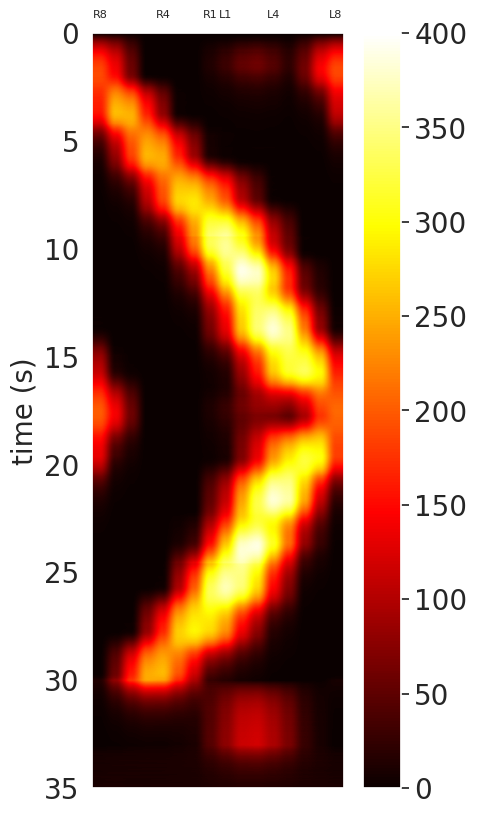

In [24]:
wedge_response = cx.show_EB_response(dur, dt, vmax = 400)

/home/ffbo/ffbo/cx_fbl/cx_fbl/cx_lib.py:1464: matplotlib.cbook.deprecation.MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


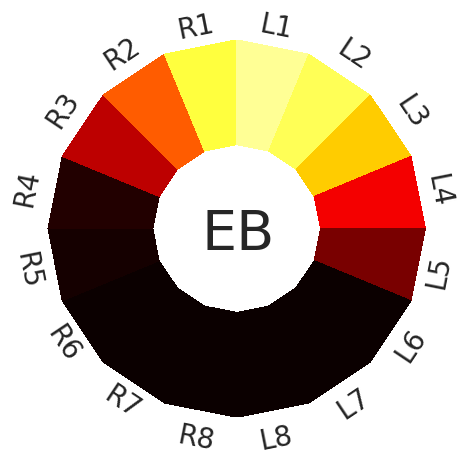

In [25]:
cx.show_EB_response_at_step(wedge_response, 100000, vmax = 400)